
# Maximizing Concentration of an Intermediate in a Batch Reactor

Keywords: ipopt usage, scipy.minimize_scalar, scipy.odeint, unconstrained optimization

This notebook presents an example of the finding the time period required to achieve an optimal result. Because the period of operation is an unknown 

## Problem Statement

A desired product $B$ is as an intermediate in a series reactions

$$
\begin{align}
A \overset{k_A}{\longrightarrow} B \overset{k_B}{\longrightarrow} C
\end{align}
$$

where $A$ is a raw material and $C$ is an undesired by-product. The reaction operates isothermally with rate constants $k_A = 0.5\ \mbox{min}^{-1}$ and $k_B = 0.1\ \mbox{min}^{-1}$. The raw material is a solution with concentration $C_{A,f} = 2.0\ \mbox{moles/liter}$.

A 100 liter tank is available for use as a batch reactor. How long should the reaction be operated to maximize the concentration of $B$?

## Imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize_scalar

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("ipopt") or os.path.isfile("ipopt")):
    if "google.colab" in sys.modules:
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
    else:
        try:
            !conda install -c conda-forge ipopt 
        except:
            pass

assert(shutil.which("ipopt") or os.path.isfile("ipopt"))
from pyomo.environ import *
from pyomo.dae import *

## Mathematical model

A material balance for an isothermal stirred batch reactor with a volume $V = 40$ liters and an initial concentration $C_{A,f}$ is given by

$$
\begin{align}
V\frac{dC_A}{dt} & = - V k_A C_A \\
V\frac{dC_B}{dt} & = V k_A C_A - V k_B C_B
\end{align}
$$

Eliminating the common factor $V$

$$
\begin{align}
\frac{dC_A}{dt} & = - k_A C_A \\
\frac{dC_B}{dt} & = k_A C_A - k_B C_B
\end{align}
$$

With an initial concentration $C_{A,f}$. A numerical solution to these equations is shown in the following cell.

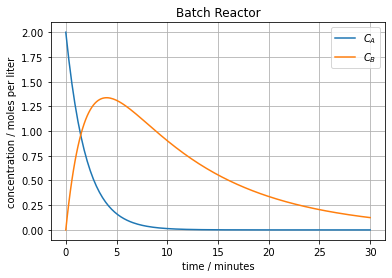

In [2]:
V = 40     # liters
kA = 0.5   # 1/min
kB = 0.1   # l/min
CAf = 2.0  # moles/liter

def batch(X, t):
    CA, CB = X
    dCA_dt = -kA*CA
    dCB_dt = kA*CA - kB*CB
    return [dCA_dt, dCB_dt]

t = np.linspace(0,30,200)
soln = odeint(batch, [CAf,0], t)
plt.plot(t, soln)
plt.xlabel('time / minutes')
plt.ylabel('concentration / moles per liter')
plt.title('Batch Reactor')
plt.legend(['$C_A$','$C_B$'])
plt.grid(True)

## Optimization with `scipy.minimize_scalar`

To find the maximum value, we first write a function to compute $C_B$ for any value of time $t$.

In [3]:
def CB(tf):
    soln = odeint(batch, [CAf, 0], [0, tf])
    return soln[-1][1]

We gain use `minimize_scalar` to find the value of $t$ that minimizes the negative value of $C_B(t)$.|

In [4]:
minimize_scalar(lambda t: -CB(t), bracket=[0, 50])

     fun: -1.3374806339222158
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 23
     nit: 19
 success: True
       x: 4.023594924340666

In [5]:
tmax = minimize_scalar(lambda t: -CB(t), bracket=[0,50]).x

print('Concentration c_B has maximum', CB(tmax), 'moles/liter at time', tmax, 'minutes.')

Concentration c_B has maximum 1.3374806339222158 moles/liter at time 4.023594924340666 minutes.


## Solution using Pyomo

The variable to be found is the time $t_f$ corresponding to the maximum concentration of $B$. For this purpose we introduce a scaled time

$$\tau = \frac{t}{t_f}$$

so that $\tau=1$ as the desired solution. The problem then reads

$$
\begin{align}
\max_{t_f} C_B(\tau=1)
\end{align}
$$

subject to

$$
\begin{align}
\frac{dC_A}{d\tau} & = - t_f k_A C_A \\
\frac{dC_B}{d\tau} & = t_f(k_A C_A - k_B C_B)
\end{align}
$$

The solution to this problem is implemented as a solution to the following Pyomo model.

In [6]:
V   = 40    # liters
kA  = 0.5   # 1/min
kB  = 0.1   # l/min
cAf = 2.0   # moles/liter

m = ConcreteModel()

m.tau = ContinuousSet(bounds=(0, 1))

m.tf = Var(domain=NonNegativeReals)
m.cA = Var(m.tau, domain=NonNegativeReals)
m.cB = Var(m.tau, domain=NonNegativeReals)

m.dcA = DerivativeVar(m.cA)
m.dcB = DerivativeVar(m.cB)

m.odeA = Constraint(m.tau, 
    rule=lambda m, tau: m.dcA[tau] == m.tf*(-kA*m.cA[tau]) if tau > 0 else Constraint.Skip)
m.odeB = Constraint(m.tau,
    rule=lambda m, tau: m.dcB[tau] == m.tf*(kA*m.cA[tau] - kB*m.cB[tau]) if tau > 0 else Constraint.Skip)

m.ic = ConstraintList()
m.ic.add(m.cA[0]  == cAf)
m.ic.add(m.cB[0]  == 0)

m.obj = Objective(expr=m.cB[1], sense=maximize)

TransformationFactory('dae.collocation').apply_to(m)
SolverFactory('ipopt').solve(m)
print('Concentration c_B has maximum', m.cB[1](), 'moles/liter at time', m.tf(), 'minutes.')

Concentration c_B has maximum 1.3374805810221082 moles/liter at time 4.023594178375689 minutes.
